In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import time
import sklearn
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import sklearn
from tabulate import tabulate
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.tree import ExtraTreeClassifier
evaluate={'Acc':"Accuracy", 'b_Acc':"Balanced Accuracy", 'F1':"F1 Score", 'kap':"Kappa", 'ROC':"Roc"}

In [3]:
import time

# sleep for 3 seconds
print('Sleep time: ', str(3600), 'seconds')
#time.sleep(3600)
print('Woke up after: ', str(3), 'seconds')

Sleep time:  3600 seconds
Woke up after:  3 seconds


In [4]:
def clean_data(X):
    # Convert to float to handle NaN values
    X = X.astype(np.float64)
    # Replace inf and -inf with NaN
    X[np.isinf(X)] = np.nan
    # Fill NaN with 0 or a specific value
    X = np.nan_to_num(X)
    return X

In [5]:
def GA(train,test,cols,gen_number=25,outputcsv="GA_output.csv"):
    #defining various steps required for the genetic algorithm
    # GA adapted from https://datascienceplus.com/genetic-algorithm-in-machine-learning-using-python/
    def initilization_of_population(size, n_feat):
        population = []
        for i in range(size):
            chromosome = np.ones(n_feat, dtype=bool)  # Thay np.bool bằng bool
            chromosome[:int(0.3 * n_feat)] = False
            np.random.shuffle(chromosome)
            population.append(chromosome)
        return population

    def fitness_score(population):
        scores = []
        for chromosome in population:
            # Chọn các cột từ X_train và X_test dựa trên chromosome
            try:
                selected_columns = X_train.columns[chromosome]  # Lấy các cột đã chọn
                logmodel.fit(X_train[selected_columns], y_train)
                predictions = logmodel.predict(X_test[selected_columns])
                scores.append(sklearn.metrics.f1_score(y_test, predictions, average="macro"))
            except Exception as e:
                scores.append(0)  # Trả về điểm 0 nếu có lỗi
        scores, population = np.array(scores), np.array(population)
        inds = np.argsort(scores)
        return list(scores[inds][::-1]), list(population[inds, :][::-1])


    def selection(pop_after_fit,n_parents):
        population_nextgen = []
        for i in range(n_parents):
            population_nextgen.append(pop_after_fit[i])
        return population_nextgen

    def crossover(pop_after_sel):
        population_nextgen=pop_after_sel
        for i in range(len(pop_after_sel)):
            child=pop_after_sel[i]
            child[3:7]=pop_after_sel[(i+1)%len(pop_after_sel)][3:7]
            population_nextgen.append(child)
        return population_nextgen

    def mutation(pop_after_cross,mutation_rate):
        population_nextgen = []
        for i in range(0,len(pop_after_cross)):
            chromosome = pop_after_cross[i]
            for j in range(len(chromosome)):
                if random.random() < mutation_rate:
                    chromosome[j]= not chromosome[j]
            population_nextgen.append(chromosome)
        #print(population_nextgen)
        return population_nextgen

    def generations(size,n_feat,n_parents,mutation_rate,n_gen,X_train,
                                       X_test, y_train, y_test):

        best_chromo= []
        best_score= []
        population_nextgen=initilization_of_population(size,n_feat)
        for i in tqdm(range(n_gen)):
            second=time.time()
            scores, pop_after_fit = fitness_score(population_nextgen)
            #print(scores[:2])
            zaman=time.time()-second

            ths.write(f"{np.mean(scores)},{np.mean(scores)},{zaman}\n")
            
            pop_after_sel = selection(pop_after_fit,n_parents)
            pop_after_cross = crossover(pop_after_sel)
            population_nextgen = mutation(pop_after_cross,mutation_rate)
            best_chromo.append(pop_after_fit[0])
            best_score.append(scores[0])
        return best_chromo,best_score

    df = pd.read_csv(train,usecols=cols)#,header=None )
    df=df.fillna(0)
    #df = df.sample(n = 10000)
    X_train =df[df.columns[0:-1]]
    #X_train=np.array(X_train)
    df[df.columns[-1]] = df[df.columns[-1]].astype('category')
    y_train=df[df.columns[-1]].cat.codes  
    df = pd.read_csv(test,usecols=cols)#,header=None )
    df=df.fillna(0)
    #df = df.sample(n = 10000)
    X_test =df[df.columns[0:-1]]
    #X_test=np.array(X_test)
    df[df.columns[-1]] = df[df.columns[-1]].astype('category')
    y_test=df[df.columns[-1]].cat.codes  

    ths = open(f"./{outputcsv}", "w")
    ths.write("MEAN,STD,TIME\n")
    logmodel=ExtraTreeClassifier()
    #print ('%-30s %-30s %-30s' % ("MEAN","STD","TIME"))
    chromo,score=generations(size=200,n_feat=X_train.shape[1],n_parents=120,mutation_rate=0.005,
                         n_gen=gen_number,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test)
    #logmodel.fit(X_train.iloc[:,chromo[-1]],y_train)
    #predictions = logmodel.predict(X_test.iloc[:,chromo[-1]])
    #print("F1 Score score after genetic algorithm is= "+str(sklearn.metrics.f1_score(y_test,predictions,average= "macro")))
    ths.close()
    sonuç=[]
    for k,j in enumerate(chromo):
        temp=X_train.iloc[:,j]
        temp=list(temp.columns)
        temp.append("Label")
        sonuç.append(temp)
    max_length = max(len(x) for x in sonuç)
    normalized_sonuç = [x + [None] * (max_length - len(x)) for x in sonuç]  # Làm đầy danh sách để có cùng độ dài
    np.save(outputcsv.replace("csv", "npy"), np.array(normalized_sonuç, dtype=object))
    gf = pd.read_csv(outputcsv)
    gf=gf["MEAN"].values
    gf=np.argmax(gf) 
    return sonuç[gf],gf

In [6]:
def folder(f_name): #this function creates a folder named "attacks" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")

In [7]:
def find_the_way(path,file_format,con=""):
    files_add = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if file_format in file:
                if con in file:
                    files_add.append(os.path.join(r, file))  
            
    return files_add

In [8]:
ml_list={"ET": ExtraTreeClassifier()}#,"SVC":SVC()}}

In [9]:
def target_name(name):
    df = pd.read_csv(name,usecols=["Label"])
    target_names=sorted(list(df["Label"].unique()))
    return target_names

In [10]:
folder("results")
folder("results/beforeGA/")
folder("results/afterGA/")
folder("pdfs")

## Calculation of evaluations

In [11]:
def score(train_time,test_time,predict,y_test,class_based_results,repeat,cv,dname,ml,sw):
    train_time=train_time[0]
    test_time=test_time[0]
    rc=sklearn.metrics.recall_score(y_test, predict,average= "macro")
    pr=sklearn.metrics.precision_score(y_test, predict,average= "macro")
    f_1=sklearn.metrics.f1_score(y_test, predict,average= "macro")     
    accuracy=sklearn.metrics.accuracy_score(y_test, predict)
    accuracy_b=sklearn.metrics.balanced_accuracy_score( y_test,predict)
    kappa=sklearn.metrics.cohen_kappa_score(y_test, predict,labels=None, weights=None, sample_weight=None)
    try:
        roc=sklearn.metrics.roc_auc_score(y_test, predict)
    except:roc=0
    report = sklearn.metrics.classification_report(y_test, predict, target_names=target_names,output_dict=True)
    cr = pd.DataFrame(report).transpose()
    line=[dname,sw,repeat,cv,ml,accuracy,accuracy_b,pr,rc,f_1,kappa,roc,train_time,test_time]

    if class_based_results.empty:
        class_based_results =cr
    else:
        class_based_results = class_based_results.add(cr, fill_value=0)
    return class_based_results,line

In [12]:
def ML_CV(loop1,loop2,output_csv,cols,dname,sw):
    fold=5
    repetition=10

    for ii in ml_list:
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        lines=[["Dataset","SW","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
        for i in range(repetition):

            #rnd = random()
            
            #kfold = sklearn.model_selection.KFold(n_splits=fold, shuffle=True, random_state=int(rnd*100))  
            cv=0
            df = pd.read_csv(loop1,usecols=cols)#,header=None )
            df=df.fillna(0)
            X_train =df[df.columns[0:-1]]
            X_train=np.array(X_train)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_train=df[df.columns[-1]].cat.codes  

            df = pd.read_csv(loop2,usecols=cols)#,header=None )
            df=df.fillna(0)
            X_test =df[df.columns[0:-1]]
            X_test=np.array(X_test)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_test=df[df.columns[-1]].cat.codes  
            
            # Clean data
            X_train = clean_data(X_train)
            X_test = clean_data(X_test)

            #dname=loop1  [6:-13]  
            results_y=[]
            cv+=1
            results_y.append(y_test)

            precision=[]
            recall=[]
            f1=[]
            accuracy=[]
            train_time=[]
            test_time=[]
            total_time=[]
            kappa=[]
            accuracy_b=[]

                #machine learning algorithm is applied in this section
            clf = ml_list[ii]#choose algorithm from ml_list dictionary
            second=time.time()
            clf.fit(X_train, y_train)
            train_time.append(float((time.time()-second)) )
            second=time.time()
            predict =clf.predict(X_test)
            test_time.append(float((time.time()-second)) )

            altime=0
            class_based_results,line=score(train_time,test_time,predict,y_test,class_based_results,cv,i,dname,ii,sw)
            lines.append(line)
            df_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, predict))
            if cm.empty:
                cm =df_cm
            else:
                cm = cm.add(df_cm, fill_value=0)

        results = pd.DataFrame (lines[1:], columns = lines[0])
        results.to_csv(output_csv.replace("ML",ii),index=False)
        results=results.round(3)
        print (tabulate(results, headers=list(results.columns)))
        print()
        
        class_based_results=class_based_results/repetition
        print (tabulate(class_based_results, headers=list(class_based_results.columns)))
        class_based_results.to_csv(output_csv.replace(".csv","class_based_results.csv"))
        if True:
            cm=cm//repetition
            graph_name=output_csv[:-4]+"_confusion matrix.pdf"   
            plt.figure(figsize = (5,3.5))
            sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True, fmt='g')
            plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
            plt.show()
            #print(cm)
            print("\n\n\n")             


In [13]:
#find_the_way("../csvs","csv",con="")

In [14]:
file_list={
'SYN': ['../csvs\\dos-synflooding-1-dec.pcap_Flow.csv', '../csvs\\dos-synflooding-5-dec.pcap_Flow.csv'],
'HTTP': ['../csvs\\mirai-httpflooding-4-dec.pcap_Flow.csv', '../csvs\\mirai-httpflooding-3-dec.pcap_Flow.csv'],
'ACK': ['../csvs\\mirai-ackflooding-4-dec.pcap_Flow.csv', '../csvs\\mirai-ackflooding-3-dec.pcap_Flow.csv'],
'UDP': ['../csvs\\mirai-udpflooding-4-dec.pcap_Flow.csv', '../csvs\\mirai-udpflooding-3-dec.pcap_Flow.csv'],
'ARP': ['../csvs\\mitm-arpspoofing-6-dec.pcap_Flow.csv',  '../csvs\\mitm-arpspoofing-5-dec.pcap_Flow.csv'],
'SP': ['../csvs\\scan-hostport-3-dec.pcap_Flow.csv', '../csvs\\scan-hostport-5-dec.pcap_Flow.csv'],
'BF': ['../csvs\\mirai-hostbruteforce-5-dec.pcap_Flow.csv', '../csvs\\mirai-hostbruteforce-3-dec.pcap_Flow.csv'],
'OS': ['../csvs\\scan-portos-3-dec.pcap_Flow.csv', '../csvs\\scan-portos-5-dec.pcap_Flow.csv'],
"SCHD":['../csvs\\scan-hostport-3-dec.pcap_Flow.csv', '../csvs\\scan-hostport-4-dec.pcap_Flow.csv'],
"MHDis":['../csvs\\mirai-hostbruteforce-3-dec.pcap_Flow.csv', '../csvs\\mirai-hostbruteforce-5-dec.pcap_Flow.csv' ]}

In [15]:
import json
with open('GA_input.json', 'r') as fp:
    feature_list = json.load(fp)

SYN
['ACK Flag Cnt', 'Active Max', 'Active Mean', 'Active Min', 'Active Std', 'Bwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Tot', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Min', 'Bwd Pkt Len Std', 'Bwd Pkts/s', 'Bwd PSH Flags', 'Bwd Seg Size Avg', 'Flow Byts/s', 'Flow Duration', 'Flow IAT Max', 'Flow IAT Mean', 'Flow IAT Min', 'Flow IAT Std', 'Flow Pkts/s', 'Fwd Act Data Pkts', 'Fwd Header Len', 'Fwd IAT Max', 'Fwd IAT Mean', 'Fwd IAT Min', 'Fwd IAT Std', 'Fwd IAT Tot', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Fwd Pkts/s', 'Fwd Seg Size Avg', 'Idle Max', 'Idle Mean', 'Idle Min', 'Idle Std', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Min', 'Pkt Len Std', 'Pkt Len Var', 'Pkt Size Avg', 'Protocol', 'PSH Flag Cnt', 'Src Port', 'Subflow Bwd Byts', 'Subflow Bwd Pkts', 'Subflow Fwd Byts', 'Subflow Fwd Pkts', 'SYN Flag Cnt', 'Tot Bwd Pkts', 'Tot Fwd Pkts', 'TotLen Bwd Pkts', 'TotLen Fwd Pkts', 'Label']
    Dataset      SW    T

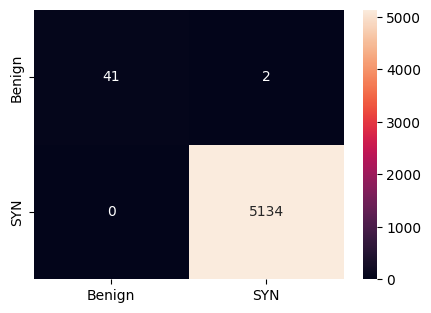





HTTP
['Active Max', 'Active Mean', 'Active Min', 'Active Std', 'Bwd Header Len', 'Bwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Tot', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Min', 'Bwd Pkt Len Std', 'Bwd PSH Flags', 'Bwd Seg Size Avg', 'CWE Flag Count', 'Down/Up Ratio', 'Dst Port', 'ECE Flag Cnt', 'FIN Flag Cnt', 'Flow Duration', 'Flow IAT Min', 'Fwd Act Data Pkts', 'Fwd Header Len', 'Fwd IAT Max', 'Fwd IAT Min', 'Fwd IAT Tot', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Fwd Pkts/s', 'Fwd Seg Size Avg', 'Idle Max', 'Idle Mean', 'Idle Min', 'Idle Std', 'Init Bwd Win Byts', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Min', 'Pkt Len Std', 'Pkt Len Var', 'Pkt Size Avg', 'Protocol', 'PSH Flag Cnt', 'RST Flag Cnt', 'Subflow Bwd Byts', 'Subflow Bwd Pkts', 'Subflow Fwd Byts', 'Subflow Fwd Pkts', 'SYN Flag Cnt', 'Tot Bwd Pkts', 'Tot Fwd Pkts', 'TotLen Bwd Pkts', 'TotLen Fwd Pkts', 'Label']
    Dataset      SW    T    CV  ML   

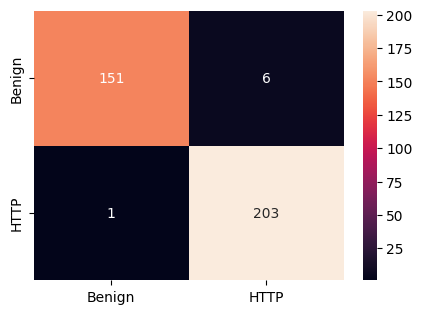





ACK
['ACK Flag Cnt', 'Active Max', 'Active Mean', 'Active Min', 'Bwd Header Len', 'Bwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Tot', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Bwd Pkts/s', 'Bwd Seg Size Avg', 'Flow Byts/s', 'Flow Duration', 'Flow IAT Max', 'Flow IAT Mean', 'Flow IAT Min', 'Flow Pkts/s', 'Fwd Act Data Pkts', 'Fwd IAT Min', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Fwd Pkts/s', 'Fwd Seg Size Avg', 'Idle Max', 'Idle Mean', 'Idle Min', 'Idle Std', 'Init Bwd Win Byts', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'Pkt Size Avg', 'Src Port', 'Subflow Bwd Byts', 'Subflow Bwd Pkts', 'Subflow Fwd Byts', 'SYN Flag Cnt', 'Tot Bwd Pkts', 'TotLen Bwd Pkts', 'TotLen Fwd Pkts', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK 

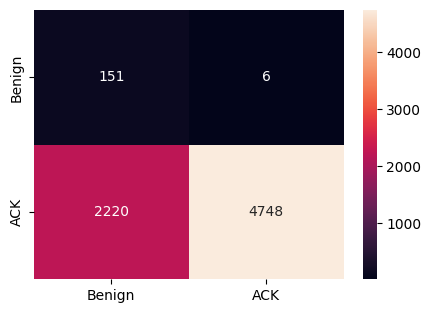





UDP
['Bwd Pkt Len Max', 'Flow IAT Max', 'Flow IAT Min', 'Flow IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Fwd IAT Std', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Pkt Len Max', 'Pkt Size Avg', 'Src Port', 'Subflow Bwd Byts', 'Subflow Fwd Byts', 'TotLen Bwd Pkts', 'TotLen Fwd Pkts', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           5    1     0  ET    0.457    0.543   0.714  0.543  0.38   0.072  0.543    0.003     0.001
 1  UDP           5    1     1  ET    0.997    0.998   0.997  0.998  0.997  0.995  0.998    0.002     0.001
 2  UDP           5    1     2  ET    0.406    0.5     0.203  0.5    0.289  0      0.5      0.001     0.001
 3  UDP           5    1     3  ET    0.468    0.552   0.716  0.552  0.396  0.086  0.552    0.002     0
 4  UDP           5    1     4  ET    0.457    0.543   0.714  0.543

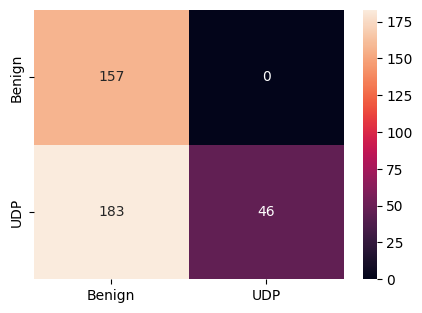





ARP
['ACK Flag Cnt', 'Active Max', 'Active Mean', 'Active Min', 'Active Std', 'Bwd Header Len', 'Bwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Tot', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Min', 'Bwd Pkt Len Std', 'Bwd Pkts/s', 'Bwd PSH Flags', 'Bwd Seg Size Avg', 'Down/Up Ratio', 'Dst Port', 'FIN Flag Cnt', 'Flow Byts/s', 'Flow Duration', 'Flow IAT Max', 'Flow IAT Mean', 'Flow IAT Min', 'Flow IAT Std', 'Flow Pkts/s', 'Fwd Act Data Pkts', 'Fwd Header Len', 'Fwd IAT Max', 'Fwd IAT Mean', 'Fwd IAT Min', 'Fwd IAT Std', 'Fwd IAT Tot', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Fwd Pkts/s', 'Fwd Seg Size Avg', 'Idle Max', 'Idle Mean', 'Idle Min', 'Idle Std', 'Init Bwd Win Byts', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Min', 'Pkt Len Std', 'Pkt Len Var', 'Pkt Size Avg', 'Protocol', 'PSH Flag Cnt', 'Src Port', 'Subflow Bwd Byts', 'Subflow Bwd Pkts', 'Subflow Fwd Byts', 'Subflow Fwd Pkts', 'SYN Flag Cnt', 'Tot Bwd Pkts',

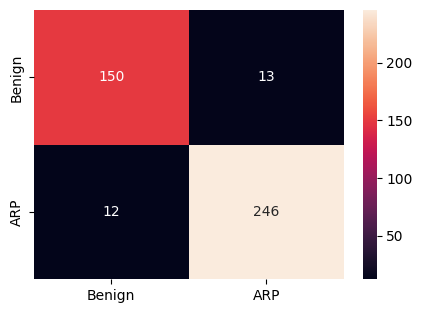





SP
['ACK Flag Cnt', 'Active Max', 'Active Mean', 'Active Min', 'Active Std', 'Bwd Header Len', 'Bwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Tot', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Min', 'Bwd Pkt Len Std', 'Bwd Pkts/s', 'Bwd PSH Flags', 'Bwd Seg Size Avg', 'Down/Up Ratio', 'Dst Port', 'FIN Flag Cnt', 'Flow Byts/s', 'Flow Duration', 'Flow IAT Max', 'Flow IAT Mean', 'Flow IAT Min', 'Flow IAT Std', 'Flow Pkts/s', 'Fwd Act Data Pkts', 'Fwd Header Len', 'Fwd IAT Max', 'Fwd IAT Mean', 'Fwd IAT Min', 'Fwd IAT Std', 'Fwd IAT Tot', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Fwd Pkts/s', 'Fwd Seg Size Avg', 'Idle Max', 'Idle Mean', 'Idle Min', 'Idle Std', 'Init Bwd Win Byts', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Min', 'Pkt Len Std', 'Pkt Len Var', 'Pkt Size Avg', 'Protocol', 'PSH Flag Cnt', 'RST Flag Cnt', 'Subflow Bwd Byts', 'Subflow Bwd Pkts', 'Subflow Fwd Byts', 'Subflow Fwd Pkts', 'SYN Flag Cnt', 'Tot Bwd Pkt

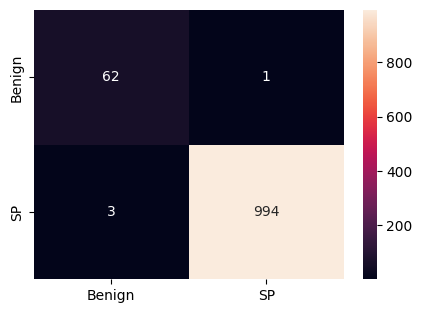





BF
['Active Max', 'Active Mean', 'Active Min', 'Active Std', 'Bwd Header Len', 'Bwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Tot', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Min', 'Bwd Pkt Len Std', 'Bwd Pkts/s', 'Bwd Seg Size Avg', 'Dst Port', 'Flow Byts/s', 'Flow Duration', 'Flow IAT Max', 'Flow IAT Mean', 'Flow IAT Min', 'Flow IAT Std', 'Flow Pkts/s', 'Fwd Act Data Pkts', 'Fwd Header Len', 'Fwd IAT Max', 'Fwd IAT Mean', 'Fwd IAT Min', 'Fwd IAT Std', 'Fwd IAT Tot', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Fwd Pkts/s', 'Fwd Seg Size Avg', 'Idle Max', 'Idle Mean', 'Idle Min', 'Init Bwd Win Byts', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'Pkt Size Avg', 'Src Port', 'Subflow Bwd Byts', 'Subflow Bwd Pkts', 'Subflow Fwd Byts', 'Subflow Fwd Pkts', 'Tot Bwd Pkts', 'Tot Fwd Pkts', 'TotLen Bwd Pkts', 'TotLen Fwd Pkts', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1

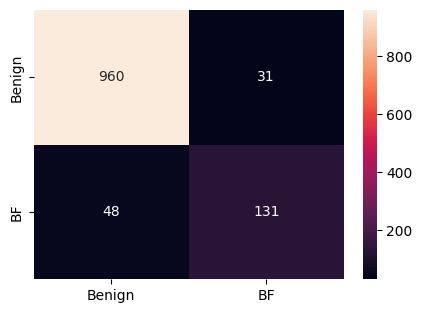





OS
['ACK Flag Cnt', 'Active Max', 'Active Mean', 'Active Min', 'Active Std', 'Bwd Header Len', 'Bwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Tot', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Min', 'Bwd Pkt Len Std', 'Bwd Pkts/s', 'Bwd PSH Flags', 'Bwd Seg Size Avg', 'Down/Up Ratio', 'Dst Port', 'Flow Byts/s', 'Flow Duration', 'Flow IAT Max', 'Flow IAT Mean', 'Flow IAT Min', 'Flow IAT Std', 'Flow Pkts/s', 'Fwd Act Data Pkts', 'Fwd Header Len', 'Fwd IAT Max', 'Fwd IAT Mean', 'Fwd IAT Min', 'Fwd IAT Std', 'Fwd IAT Tot', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Fwd Pkts/s', 'Fwd Seg Size Avg', 'Idle Max', 'Idle Mean', 'Idle Min', 'Idle Std', 'Init Bwd Win Byts', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Min', 'Pkt Len Std', 'Pkt Len Var', 'Pkt Size Avg', 'Protocol', 'PSH Flag Cnt', 'RST Flag Cnt', 'Subflow Bwd Byts', 'Subflow Bwd Pkts', 'Subflow Fwd Byts', 'Subflow Fwd Pkts', 'SYN Flag Cnt', 'Tot Bwd Pkts', 'Tot Fwd Pkt

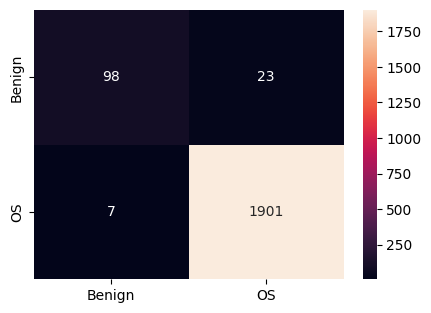





SCHD
['ACK Flag Cnt', 'Active Max', 'Active Mean', 'Active Min', 'Active Std', 'Bwd Header Len', 'Bwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Tot', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Min', 'Bwd Pkt Len Std', 'Bwd Pkts/s', 'Bwd PSH Flags', 'Bwd Seg Size Avg', 'Down/Up Ratio', 'Dst Port', 'FIN Flag Cnt', 'Flow Byts/s', 'Flow Duration', 'Flow IAT Max', 'Flow IAT Mean', 'Flow IAT Min', 'Flow IAT Std', 'Flow Pkts/s', 'Fwd Act Data Pkts', 'Fwd Header Len', 'Fwd IAT Max', 'Fwd IAT Mean', 'Fwd IAT Min', 'Fwd IAT Std', 'Fwd IAT Tot', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Fwd Pkts/s', 'Fwd Seg Size Avg', 'Idle Max', 'Idle Mean', 'Idle Min', 'Idle Std', 'Init Bwd Win Byts', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Min', 'Pkt Len Std', 'Pkt Len Var', 'Pkt Size Avg', 'Protocol', 'PSH Flag Cnt', 'RST Flag Cnt', 'Subflow Bwd Byts', 'Subflow Bwd Pkts', 'Subflow Fwd Byts', 'Subflow Fwd Pkts', 'SYN Flag Cnt', 'Tot Bwd P

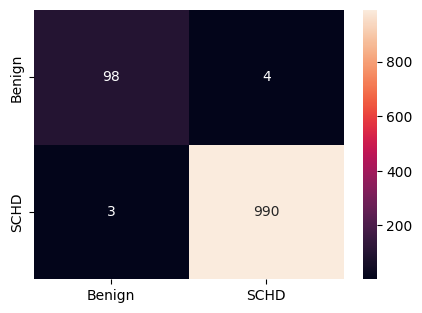





MHDis
['Active Mean', 'Active Min', 'Active Std', 'Bwd Header Len', 'Bwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Tot', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Min', 'Bwd Pkt Len Std', 'Bwd Pkts/s', 'Bwd Seg Size Avg', 'Dst Port', 'Flow Byts/s', 'Flow Duration', 'Flow IAT Max', 'Flow IAT Mean', 'Flow IAT Min', 'Flow IAT Std', 'Flow Pkts/s', 'Fwd Act Data Pkts', 'Fwd Header Len', 'Fwd IAT Max', 'Fwd IAT Mean', 'Fwd IAT Min', 'Fwd IAT Std', 'Fwd IAT Tot', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Fwd Pkts/s', 'Fwd Seg Size Avg', 'Idle Max', 'Idle Mean', 'Idle Min', 'Idle Std', 'Init Bwd Win Byts', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'Pkt Size Avg', 'Src Port', 'Subflow Bwd Byts', 'Subflow Bwd Pkts', 'Subflow Fwd Byts', 'Subflow Fwd Pkts', 'Tot Bwd Pkts', 'Tot Fwd Pkts', 'TotLen Bwd Pkts', 'TotLen Fwd Pkts', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F

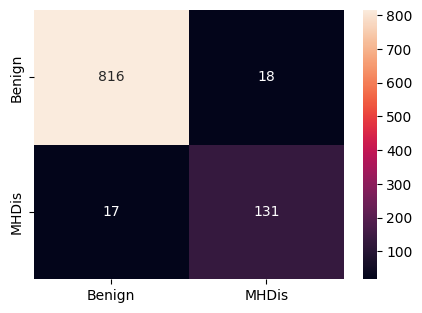

In [16]:
for file in file_list:
    print(file)
    features=feature_list[file]
    train=file_list[file][0]
    test=file_list[file][1]
    #feature,_=GA(train,test,features,gen_number=25,outputcsv=f"{file}_ET_chosed_GA_output.csv")
    feature=features
    print(feature)
    #GA_output[file]=feature
    output_csv=f"./results/beforeGA/{file}_chosed_output_ML_.csv"
    target_names=["Benign",file]
    ML_CV(train,test,output_csv,feature,file,5)   

In [17]:
GA_output={}

SYN


100%|██████████| 25/25 [04:09<00:00,  9.99s/it]


['Src Port', 'Protocol', 'Flow Duration', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Min', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow IAT Std', 'Fwd IAT Mean', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Bwd PSH Flags', 'Fwd Header Len', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Var', 'SYN Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Active Mean', 'Active Std', 'Active Max', 'Idle Max', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           5    1     0  ET        1    0.977       1  0.977  0.988  0.977  0.977    0.01      0.001
 1  SYN           5    1     1  ET        1    0.989       1 

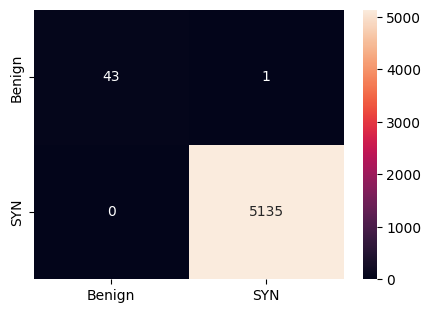





HTTP


100%|██████████| 25/25 [01:31<00:00,  3.67s/it]


['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Fwd IAT Tot', 'Bwd IAT Std', 'Bwd IAT Min', 'Bwd PSH Flags', 'Bwd Header Len', 'Pkt Len Min', 'Pkt Len Var', 'FIN Flag Cnt', 'RST Flag Cnt', 'CWE Flag Count', 'Down/Up Ratio', 'Pkt Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Bwd Pkts', 'Fwd Act Data Pkts', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Max', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          5    1     0  ET    0.989    0.987   0.99   0.987  0.989  0.977  0.987    0.002     0
 1  HTTP          5    1     1  ET    0.986    0.984   0.988  0.984  0.986  0.972  0.98

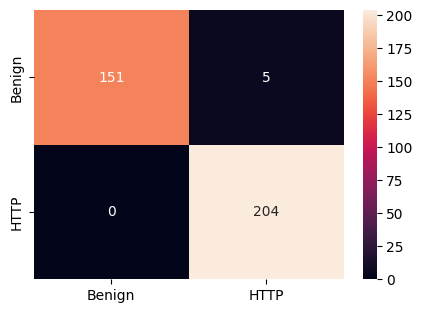





ACK


100%|██████████| 25/25 [02:03<00:00,  4.95s/it]


['Fwd Pkt Len Max', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Max', 'Bwd IAT Mean', 'Bwd IAT Max', 'Bwd IAT Min', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Std', 'Pkt Len Var', 'SYN Flag Cnt', 'ACK Flag Cnt', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Active Mean', 'Active Max', 'Active Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           5    1     0  ET    0.989    0.973   0.844  0.973  0.898  0.796  0.973    0.001     0.002
 1  ACK           5    1     1  ET    0.996    0.989   0.93   0.989  0.958  0.915  0.989    0.001     0.003
 2  ACK           5    1     2  ET    0.968    0.968   0.701  0.968  0.776  0.556  0.968    0.002     0.003
 3  ACK           5    1     

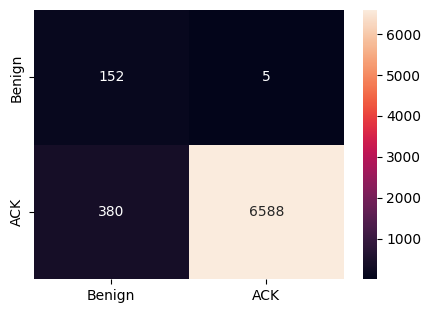





UDP


100%|██████████| 25/25 [01:00<00:00,  2.40s/it]


['Src Port', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Bwd Pkt Len Max', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Min', 'Pkt Len Max', 'Pkt Size Avg', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           5    1     0  ET    0.406    0.5     0.203  0.5    0.289  0      0.5      0.001     0
 1  UDP           5    1     1  ET    1        1       1      1      1      1      1        0.001     0.001
 2  UDP           5    1     2  ET    0.997    0.997   0.998  0.997  0.997  0.995  0.997    0.001     0.001
 3  UDP           5    1     3  ET    1        1       1      1      1      1      1        0.001     0
 4  UDP           5    1     4  ET    1        1       1      1      1      1      1        0.001     0
 5  UDP           5    1     5  ET    0.767    0.803   0.815  0.

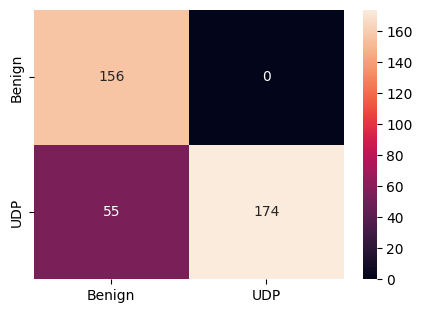





ARP


100%|██████████| 25/25 [01:24<00:00,  3.38s/it]


['Src Port', 'Dst Port', 'Protocol', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow IAT Max', 'Fwd IAT Min', 'Bwd IAT Mean', 'Bwd IAT Max', 'Bwd IAT Min', 'Bwd PSH Flags', 'Fwd Header Len', 'Fwd Pkts/s', 'Pkt Len Mean', 'Pkt Len Std', 'SYN Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           5    1     0  ET    0.931    0.931   0.926  0.931  0.928  0.856  0.931    0.003     0
 1  ARP           5    1     1  ET    

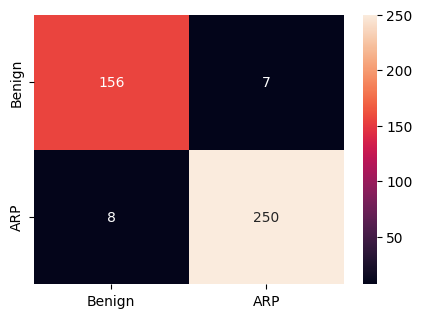





SP


100%|██████████| 25/25 [01:13<00:00,  2.92s/it]


['TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Min', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Min', 'Fwd IAT Std', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd PSH Flags', 'Fwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'ACK Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Active Mean', 'Active Std', 'Active Min', 'Idle Std', 'Idle Max', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            5    1     0  ET    1        1       1      1      1      1      1        0.001     0.

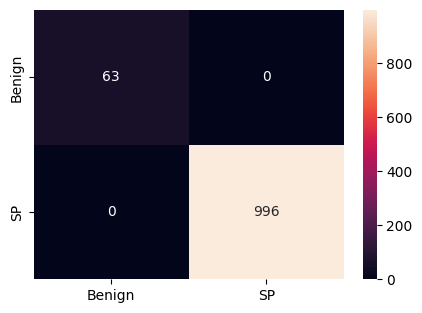





BF


100%|██████████| 25/25 [01:35<00:00,  3.80s/it]


['Src Port', 'Dst Port', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Flow IAT Max', 'Fwd IAT Tot', 'Fwd IAT Max', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Max', 'Pkt Len Std', 'Fwd Seg Size Avg', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Active Std', 'Active Max', 'Active Min', 'Idle Max', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            5    1     0  ET    0.956    0.904   0.925  0.904  0.914  0.828  0.904    0.004     0
 1  BF            5    1     1  ET    0.939    0.898   0.876  0.898  0.887  0.774  0.898    0.002     0.001
 2  BF            5    1     2  ET    0.981    0.957   0.97   0.957  0.963 

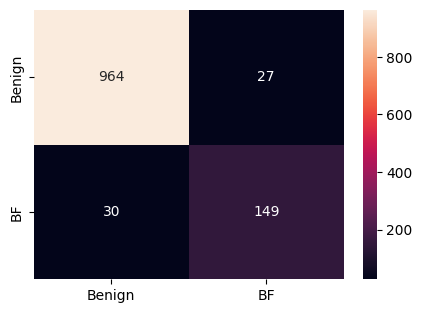





OS


100%|██████████| 25/25 [01:27<00:00,  3.51s/it]


['Dst Port', 'Protocol', 'Tot Fwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Min', 'Fwd Header Len', 'Fwd Pkts/s', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Var', 'SYN Flag Cnt', 'RST Flag Cnt', 'ACK Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Fwd Act Data Pkts', 'Active Std', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS            5    1     0  ET    0.992    0.961   0.968  0.961  0.965  0.93   0.961    0.001     0.001
 1  OS            5    1     1  ET    0.972    0.874   0.87

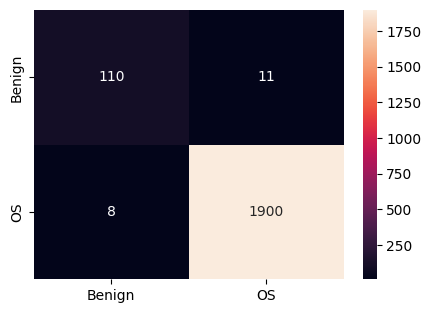





SCHD


100%|██████████| 25/25 [01:19<00:00,  3.18s/it]


['Dst Port', 'Protocol', 'Flow Duration', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Mean', 'Fwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Max', 'Fwd Header Len', 'Fwd Pkts/s', 'Pkt Len Max', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'Down/Up Ratio', 'Subflow Fwd Byts', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Active Mean', 'Active Max', 'Active Min', 'Idle Std', 'Idle Max', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          5    1     0  ET    1        1       1      1      1      1      1        0.001     0.001
 1  SCHD          5    1     1  ET    0.994    0.97    0.992  0.97   0.981 

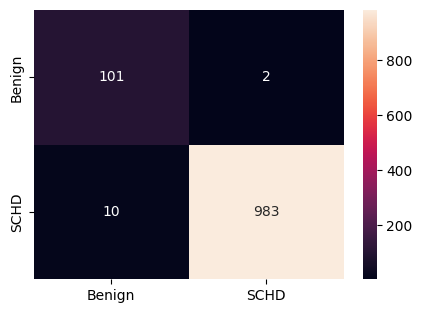





MHDis


100%|██████████| 25/25 [01:27<00:00,  3.50s/it]


['Src Port', 'Dst Port', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Mean', 'Fwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Min', 'Bwd Header Len', 'Bwd Pkts/s', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Active Mean', 'Idle Mean', 'Idle Std', 'Idle Max', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         5    1     0  ET    0.979    0.957   0.96   0.957  0.958  0.917  0.957    0.006     0.001
 1  MHDis         5    1     1  ET    0.952    0

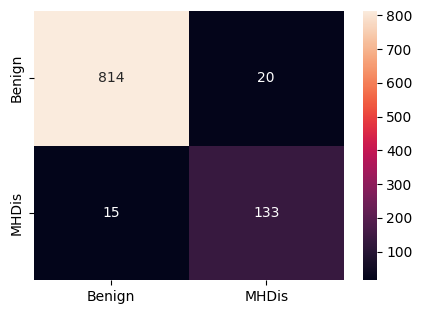

In [18]:
for file in file_list:
        print(file)
        features=feature_list[file]
        train=file_list[file][0]
        test=file_list[file][1]
        feature,_=GA(train,test,features,gen_number=25,outputcsv=f"./results/afterGA/{file}_ET_chosed_GA_output.csv")

        print(feature)
        GA_output[file]=feature
        output_csv=f"./results/afterGA/{file}_chosed_output_ML_.csv"
        target_names=["Benign",file]
        ML_CV(train,test,output_csv,feature,file,5)   

In [19]:
with open('GA_output_ET.json', 'w') as fp:
    json.dump(GA_output, fp)

In [20]:
#!shutdown /s /t 360

In [21]:
GA_output

{'SYN': ['Src Port',
  'Protocol',
  'Flow Duration',
  'TotLen Fwd Pkts',
  'TotLen Bwd Pkts',
  'Fwd Pkt Len Max',
  'Fwd Pkt Len Min',
  'Fwd Pkt Len Mean',
  'Fwd Pkt Len Std',
  'Bwd Pkt Len Min',
  'Bwd Pkt Len Std',
  'Flow Byts/s',
  'Flow IAT Std',
  'Fwd IAT Mean',
  'Fwd IAT Min',
  'Bwd IAT Tot',
  'Bwd IAT Mean',
  'Bwd IAT Std',
  'Bwd IAT Max',
  'Bwd IAT Min',
  'Bwd PSH Flags',
  'Fwd Header Len',
  'Bwd Pkts/s',
  'Pkt Len Min',
  'Pkt Len Max',
  'Pkt Len Mean',
  'Pkt Len Var',
  'SYN Flag Cnt',
  'PSH Flag Cnt',
  'ACK Flag Cnt',
  'Fwd Seg Size Avg',
  'Bwd Seg Size Avg',
  'Subflow Fwd Pkts',
  'Active Mean',
  'Active Std',
  'Active Max',
  'Idle Max',
  'Label'],
 'HTTP': ['Dst Port',
  'Protocol',
  'Flow Duration',
  'Tot Fwd Pkts',
  'Tot Bwd Pkts',
  'TotLen Bwd Pkts',
  'Fwd Pkt Len Max',
  'Fwd Pkt Len Min',
  'Fwd Pkt Len Mean',
  'Bwd Pkt Len Max',
  'Bwd Pkt Len Min',
  'Bwd Pkt Len Mean',
  'Bwd Pkt Len Std',
  'Fwd IAT Tot',
  'Bwd IAT Std',
  'Bwd 